# 🧠 ResNet-50 Training on Custom 25-Class ImageNet Mini Subset
This Colab notebook will:
- 📥 Download ImageNet Mini (1000 classes)
- ✂️ Select 25 random classes
- 🧰 Create a new subset dataset
- 🧠 Train a ResNet-50 at 224×224 resolution
- 💾 Save the best checkpoint
- 🧪 Evaluate accuracy

In [1]:
import json, os

# ✅ Hardcoded Kaggle credentials (replace with your actual values)
kaggle_credentials = {"username":"santosh993","key":"24c6fc9fab794da2aeb82937d78bd5"}

# Write kaggle.json file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_credentials, f)

# Set permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
!kaggle datasets list -s imagenet | head

ref                                                       title                                                size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
wanghaohan/imagenetsketch                                 ImageNet-Sketch                               15219198396  2019-06-18 13:45:50.200000           4216         62  0.625            
vitaliykinakh/stable-imagenet1k                           Stable ImageNet-1K                            10519983320  2022-09-08 22:19:54.953000           3645         47  0.9375           
akash2sharma/tiny-imagenet                                Tiny ImageNet                                   497536564  2018-09-27 12:11:20.917000          20469        218  0.3125           
deeptrial/miniimagenet                                 

In [2]:
# 📥 Step 1: Download ImageNet Mini (1000 classes)
!kaggle datasets download -d ifigotin/imagenetmini-1000
!unzip -q imagenetmini-1000.zip -d /content/imagenet_mini
!ls /content/imagenet_mini

Dataset URL: https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000
License(s): unknown
100% 3.91G/3.92G [01:05<00:00, 16.4MB/s]
100% 3.92G/3.92G [01:05<00:00, 64.2MB/s]
imagenet-mini


In [3]:
# ✂️ Step 2: Pick 25 classes
import os, random, shutil

src_train = '/content/imagenet_mini/imagenet-mini/train'
src_val = '/content/imagenet_mini/imagenet-mini/val'

all_classes = sorted(os.listdir(src_train))
print(f"Total classes available: {len(all_classes)}")

selected_classes = random.sample(all_classes, 25)
print("📊 Selected classes:", selected_classes)

Total classes available: 1000
📊 Selected classes: ['n04487394', 'n03483316', 'n03642806', 'n02120079', 'n01704323', 'n01843383', 'n02110627', 'n03930630', 'n09246464', 'n02791124', 'n02090379', 'n02113712', 'n02130308', 'n04147183', 'n02111277', 'n03891332', 'n01537544', 'n01872401', 'n02317335', 'n03670208', 'n01749939', 'n07892512', 'n03666591', 'n07590611', 'n04476259']


In [4]:
# 🧰 Step 3: Copy only selected classes into new dataset folder
dst_train = '/content/imagenet25/train'
dst_val = '/content/imagenet25/val'
os.makedirs(dst_train, exist_ok=True)
os.makedirs(dst_val, exist_ok=True)

for cls in selected_classes:
    shutil.copytree(os.path.join(src_train, cls), os.path.join(dst_train, cls))
    shutil.copytree(os.path.join(src_val, cls), os.path.join(dst_val, cls))

print('✅ 25-class subset created.')
!ls /content/imagenet25/train | head

✅ 25-class subset created.
n01537544
n01704323
n01749939
n01843383
n01872401
n02090379
n02110627
n02111277
n02113712
n02120079


In [5]:
# 🧠 Step 4: Data loaders with standard ImageNet transforms (256→224)
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(dst_train, transform=transform)
val_dataset   = datasets.ImageFolder(dst_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
print(f'✅ {num_classes} classes | {len(train_dataset)} train | {len(test_loader)} val')

✅ 25 classes | 841 train | 2 val


In [6]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # 1x1 convolution for dimension reduction
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 convolution for dimension increase
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                              kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet stages
        self.stage1 = self._make_stage(64, 64, 3, stride=1)      # Output: 256 channels
        self.stage2 = self._make_stage(256, 128, 4, stride=2)    # Output: 512 channels
        self.stage3 = self._make_stage(512, 256, 6, stride=2)    # Output: 1024 channels
        self.stage4 = self._make_stage(1024, 512, 3, stride=2)   # Output: 2048 channels

        # Global average pooling and final fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        # First block with specified stride
        layers.append(Bottleneck(in_channels, out_channels, stride))

        # Remaining blocks with stride 1
        for _ in range(1, num_blocks):
            layers.append(Bottleneck(out_channels * 4, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)    # 224x224x3 -> 112x112x64
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112x64 -> 56x56x64

        x = self.stage1(x)   # 56x56x64 -> 56x56x256
        x = self.stage2(x)   # 56x56x256 -> 28x28x512
        x = self.stage3(x)   # 28x28x512 -> 14x14x1024
        x = self.stage4(x)   # 14x14x1024 -> 7x7x2048

        x = self.avgpool(x)  # 7x7x2048 -> 1x1x2048
        x = torch.flatten(x, 1)
        x = self.fc(x)       # 2048 -> 1000

        return x

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os


def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradient buffers
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })



In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluating'):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy



In [9]:
# 🏋️ Step 5: Train ResNet-50
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [12]:
best_val_acc = 0
checkpoint_path = '/content/resnet50_best_25class.pth'
EPOCHS = 5
start_epoch = 0

if os.path.exists(checkpoint_path):
    print(f"🔁 Found existing checkpoint at {checkpoint_path}. Resuming training...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    print(f"✅ Resumed from epoch {start_epoch}, best_val_acc={best_val_acc:.4f}")
else:
    print("🚀 No checkpoint found. Starting training from scratch.")

# --- Training Loop ---
num_epochs = 300  # Example; replace with yours

for epoch in range(start_epoch, EPOCHS):
    print(f"\nEPOCH: {epoch+1}/{EPOCHS}")

    # Clear memory before each epoch
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    # gc.collect()

    # Training
    train(model, train_loader, criterion, optimizer, device, epoch)

    # Testing
    val_acc = test(model, test_loader, device)


    # --- Save checkpoint ---
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
    }
    if 'scheduler' in locals():
        state['scheduler_state_dict'] = scheduler.state_dict()

    torch.save(state, checkpoint_path)
    print(f"💾 Checkpoint saved at epoch {epoch+1}")

    # --- Optionally keep best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"🏆 New best model saved (val_acc={val_acc:.2f}%)")


🔁 Found existing checkpoint at /content/resnet50_best_25class.pth. Resuming training...
✅ Resumed from epoch 1, best_val_acc=0.0000

EPOCH: 2/5


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Accuracy on test set: 5.21%
💾 Checkpoint saved at epoch 2
🏆 New best model saved (val_acc=5.21%)

EPOCH: 3/5


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Accuracy on test set: 3.12%
💾 Checkpoint saved at epoch 3

EPOCH: 4/5


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Accuracy on test set: 6.25%
💾 Checkpoint saved at epoch 4
🏆 New best model saved (val_acc=6.25%)

EPOCH: 5/5


Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Accuracy on test set: 3.12%
💾 Checkpoint saved at epoch 5


In [14]:
# 🧪 Step 6: Reload and Evaluate Checkpoint
best_model = models.resnet50(weights=None)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

val_correct, val_total = 0, 0
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = best_model(x)
        val_correct += (out.argmax(1) == y).sum().item()
        val_total += y.size(0)

final_acc = val_correct / val_total
print(f'✅ Final best checkpoint accuracy: {final_acc:.4f}')

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "best_val_acc", "scheduler_state_dict". 

NameError: name 'train_losses' is not defined

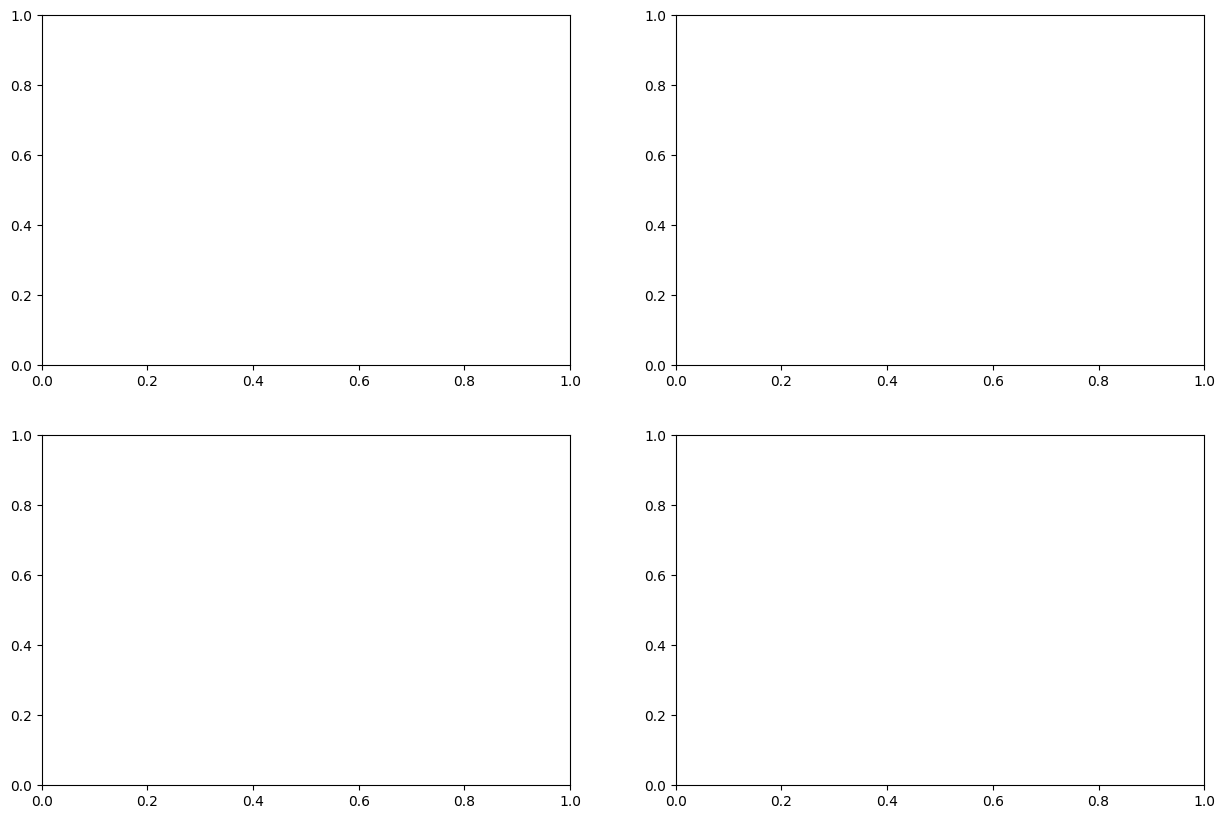

In [15]:
# Plotting results
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [17]:
# 📤 Optional: Download Checkpoint
from google.colab import files
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>